# **stackingを試してみる**

### **必要な関数・ライブラリ**

In [1]:
# データ加工・処理・分析モジュール
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import os
import math
import random

%matplotlib inline

import time

In [2]:
def set_time(dataframe, col_name):
    '''
    to_datetimeを使うための前処理
    '''
    dataframe[col_name] = dataframe[col_name].map(lambda x : transform_time(x))
    return dataframe

In [3]:
def add_time_sincos(input_data, key="datetime"):
    '''
    時間や月のデータを加える
    '''
    input_data['hour'] = input_data['datetime'].map(lambda x: int(x.hour))
    input_data['minute'] = input_data['datetime'].map(lambda x: int(x.minute))
    input_data['month'] = input_data['datetime'].map(lambda x: int(x.month))
    input_data['month_cos'] = input_data['month'].map(lambda x: np.cos(np.pi * x / 12))
    input_data['month_sin'] = input_data['month'].map(lambda x: np.sin(np.pi * x / 12))
    input_data['hour_cos'] = input_data['hour'].map(lambda x: np.cos(np.pi * x / 24))
    input_data['hour_sin'] = input_data['hour'].map(lambda x: np.sin(np.pi * x / 24))
    input_data['year'] = input_data['datetime'].map(lambda x: int(x.year))
    input_data = input_data.drop(['hour', 'month', 'minute'], axis=1)
    return input_data

In [4]:
def transform_time(x):
    '''
    set_time内で使う関数
    to_datetimeで24時をサポートしないので00に変更する処理
    '''
    str_x = str(x)
    res = ''
    if str(x)[8:10] == '24':
        res = str_x[0:4] + '-' + str_x[4:6] + '-' + str_x[6:8] + ' 00:'+str_x[10:12] 
    else:
        res = str_x[0:4] + '-' + str_x[4:6] + '-' + str_x[6:8] + ' '+ str_x[8:10] +':'+str_x[10:12]
    return res

In [5]:
def drop_nan(X, Y):
    '''
    正解データがnanであるデータの組を削除
    '''
    mask = np.isnan(Y)
    X = X[~mask]
    Y = Y[~mask]
    return X, Y

In [6]:
def scaling_output(output_30, momentum=False):
    '''
    直近2015年の総発電量に合わせて他の年の初で量も合わせる関数
    momentumで通年の傾向に従い発電量を割る
    '''
    output_30['year'] = output_30['datetime'].map(lambda x : x.year)
    y_output = output_30.groupby(['year'], as_index=False).sum()
    sum_2012 = y_output["SOLA0"+str(target_place)][0]
    sum_2013 = y_output["SOLA0"+str(target_place)][1]
    sum_2014 = y_output["SOLA0"+str(target_place)][2]
    sum_2015 = y_output["SOLA0"+str(target_place)][3]
    scaled_2012 = np.array(output_30[output_30['year'] == 2012]["SOLA0"+str(target_place)].map(lambda x : x * sum_2015/sum_2012))
    scaled_2013 = np.array(output_30[output_30['year'] == 2013]["SOLA0"+str(target_place)].map(lambda x : x * sum_2015/sum_2013))
    scaled_2014 = np.array(output_30[output_30['year'] == 2014]["SOLA0"+str(target_place)].map(lambda x : x * sum_2015/sum_2014))
    scaled_2015 = np.array(output_30[output_30['year'] == 2015]["SOLA0"+str(target_place)])
    tmp = np.r_[scaled_2012, scaled_2013, scaled_2014, scaled_2015]

    # 各年の
    if momentum:
        y_output["pre"] = y_output["SOLA0"+str(target_place)].shift(1)
        y_output["decline"] = y_output["SOLA0"+str(target_place)] / y_output["pre"]
        tendency= np.array(y_output["decline"].dropna())
        scale = 1
        for i in tendency:
            if i > 1:
                i = 1
            scale *= i
        scale = math.pow(scale, 1.0/3)
        tmp = tmp ** scale

    output_30["SOLA0"+str(target_place)] = tmp
    
    return output_30

In [7]:
def to_zero(prediction):
    '''
    2012年から2015年の間で一度も発電量がなかった時間帯を0と予測するようにする
    '''
    mask = np.array([0,0,0,0,0,0,0,0,0,0,1,1,
                    1,1,1,1,1,1,1,1,1,1,1,1,
                    1,1,1,1,1,1,1,1,1,1,1,1,
                    1,1,0,0,0,0,0,0,0,0,0,0])
    all_mask = np.array([0,0,0,0,0,0,0,0,0,0,1,1,
                        1,1,1,1,1,1,1,1,1,1,1,1,
                        1,1,1,1,1,1,1,1,1,1,1,1,
                        1,1,0,0,0,0,0,0,0,0,0,0])
    length = int(len(prediction)/48)
    
    for i in range(length-1):
        all_mask = np.r_[all_mask, mask]
    
    return prediction * all_mask

In [8]:
def to_zero_df(train_prediction):
    '''
    発電しない時間帯を全て0にする
    '''
    for column in train_prediction.columns[1:]:
        tmp = train_prediction[column]
        tmp = np.array(tmp)
        tmp = to_zero(tmp)
        train_prediction[column] = tmp
    return train_prediction

In [9]:
def minus_to_zero(x):
    if x < 0:
        return 0
    else:
        return x

In [10]:
# 発電量データ
all_output_30 = pd.read_csv('data/processed_data/out_put.tsv', delimiter = '\t')
all_output_30['datetime'] = all_output_30['datetime'].map(lambda x : pd.to_datetime(x))

### **浮島発電所について**

In [11]:
target_place = 1

In [12]:
# 発電量データ
output_30 = all_output_30[['datetime', 'SOLA0'+str(target_place)]]
output_30 = scaling_output(output_30)

/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [13]:
# いろんなモデルの予測値の集合(学習用)
train_prediction = pd.read_csv("data/predicted_data/layer_1_train_SOLA0"+str(target_place)+".csv")
train_prediction['datetime'] = train_prediction['datetime'].map(lambda x : pd.to_datetime(x))

# いろんなモデルの予測値の集合(ほんちゃん)
test_prediction = pd.read_csv("data/predicted_data/layer_1_SOLA0"+str(target_place)+".csv")
test_prediction['datetime'] = test_prediction['datetime'].map(lambda x : pd.to_datetime(x))

In [14]:
# 発電量が0の時間を0にしておく
train_prediction = to_zero_df(train_prediction)
test_prediction = to_zero_df(test_prediction)

In [15]:
# 月, 時間の情報を加える
train_prediction = add_time_sincos(train_prediction)
test_prediction = add_time_sincos(test_prediction)

In [16]:
len(train_prediction.columns), len(test_prediction.columns)

(21, 21)

In [17]:
t_s_datetime = train_prediction['datetime'][0]
t_e_datetime = train_prediction['datetime'][len(train_prediction)-1]
train_y_s_idx = output_30[output_30['datetime'] == t_s_datetime].index[0]
train_y_e_idx = output_30[output_30['datetime'] == t_e_datetime].index[0]

X = np.array(train_prediction.drop(["datetime"], axis=1))
all_X = np.array(train_prediction.drop(["datetime"], axis=1))
Y = output_30["SOLA0"+str(target_place)][train_y_s_idx:train_y_e_idx+1]
X_test = np.array(test_prediction.drop(["datetime"], axis=1))

In [18]:
X = np.array(X)
Y = np.array(Y)
X, Y = drop_nan(X, Y)

In [19]:
# 最適な深さを決める

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=int((X.shape[0] * 0.3)))

train_maes = []
val_maes = []
n = 15
n_start = 2
for i in range(n):
    rf = RandomForestRegressor(n_estimators = 10, max_depth = i+n_start)
    rf.fit(X_train, Y_train)
    Y_train_pred = rf.predict(X_train)
    Y_val_pred = rf.predict(X_val)
    train_maes.append(np.abs(Y_train_pred - Y_train).mean())
    val_maes.append(np.abs(Y_val_pred - Y_val).mean())
#     print("train_mae : ", np.abs(Y_train_pred - Y_train).mean())
#     print("val_mae : ", np.abs(Y_val_pred - Y_val).mean())

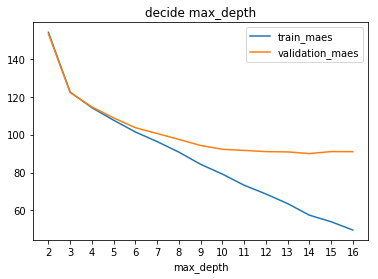

In [20]:
plt.plot(train_maes[:], label="train_maes")
plt.plot(val_maes[:], label="validation_maes")
plt.xticks(np.arange(n), np.arange(n)+n_start)
plt.xlabel("max_depth")
plt.title("decide max_depth")
plt.legend()

In [21]:
# 交差検証
t_maes = []
v_maes = []
n_splits = 5
i = 0
tmp = pd.DataFrame()
for train_idx, test_idx in KFold(n_splits=n_splits).split(X):
    X_train = X[train_idx]
    Y_train = Y[train_idx]
    X_val = X[test_idx]
    Y_val = Y[test_idx]
    
    rf = RandomForestRegressor(n_estimators = 10, max_depth = 13)
    rf.fit(X_train, Y_train)

    Y_train_pred = rf.predict(X_train)
    Y_val_pred = rf.predict(X_val)
    
    i+=1
    tmp[i] = rf.predict(X_test)
    
    t_maes.append(np.abs(Y_train_pred - Y_train).mean())
    v_maes.append( np.abs(Y_val_pred - Y_val).mean())

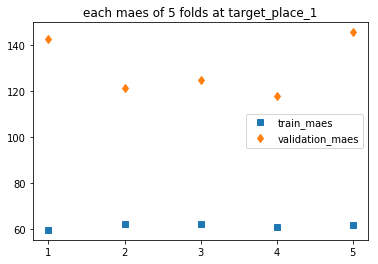

In [22]:
plt.plot(t_maes, 's', label="train_maes")
plt.plot(v_maes, 'd', label="validation_maes")
plt.legend()
plt.title("each maes of "+str(n_splits)+" folds at target_place_"+str(target_place))
plt.xticks(np.arange(n_splits), np.arange(n_splits)+1)
plt.show()

In [23]:
s_idx = test_prediction[test_prediction['datetime'] == pd.to_datetime('2016/01/01 00:00')].index[0]
e_idx = test_prediction[test_prediction['datetime'] == pd.to_datetime('2017/3/31 23:30')].index[0]
predict_data = pd.DataFrame({"datetime":test_prediction['datetime'][s_idx:e_idx+1]})
predict_data.index = np.arange(len(predict_data))

In [24]:
# 2016/01/01 00:00 ~ 2017/3/31 23:50の予測データを書き出す
predict_data["blending_"+str(target_place)] = np.array(tmp.mean(axis=1))

### **扇島発電所について**

In [25]:
target_place = 2

In [26]:
# 発電量データ
output_30 = all_output_30[['datetime', 'SOLA0'+str(target_place)]]
output_30 = scaling_output(output_30)

/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [27]:
# いろんなモデルの予測値の集合(学習用)
train_prediction = pd.read_csv("data/predicted_data/layer_1_train_SOLA0"+str(target_place)+".csv")
train_prediction['datetime'] = train_prediction['datetime'].map(lambda x : pd.to_datetime(x))

# いろんなモデルの予測値の集合(ほんちゃん)
test_prediction = pd.read_csv("data/predicted_data/layer_1_SOLA0"+str(target_place)+".csv")
test_prediction['datetime'] = test_prediction['datetime'].map(lambda x : pd.to_datetime(x))

In [28]:
# 発電量が0の時間を0にしておく
train_prediction = to_zero_df(train_prediction)
test_prediction = to_zero_df(test_prediction)

In [29]:
# 月, 時間の情報を加える
train_prediction = add_time_sincos(train_prediction)
test_prediction = add_time_sincos(test_prediction)

In [30]:
len(train_prediction.columns), len(test_prediction.columns)

(21, 21)

In [31]:
t_s_datetime = train_prediction['datetime'][0]
t_e_datetime = train_prediction['datetime'][len(train_prediction)-1]
train_y_s_idx = output_30[output_30['datetime'] == t_s_datetime].index[0]
train_y_e_idx = output_30[output_30['datetime'] == t_e_datetime].index[0]

X = np.array(train_prediction.drop(["datetime"], axis=1))
all_X = np.array(train_prediction.drop(["datetime"], axis=1))
Y = output_30["SOLA0"+str(target_place)][train_y_s_idx:train_y_e_idx+1]
X_test = np.array(test_prediction.drop(["datetime"], axis=1))

In [32]:
X = np.array(X)
Y = np.array(Y)
X, Y = drop_nan(X, Y)

In [33]:
# 最適な深さを決める

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=int((X.shape[0] * 0.3)))

train_maes = []
val_maes = []
n = 15
n_start = 2
for i in range(n):
    rf = RandomForestRegressor(n_estimators = 10, max_depth = i+n_start)
    rf.fit(X_train, Y_train)
    Y_train_pred = rf.predict(X_train)
    Y_val_pred = rf.predict(X_val)
    train_maes.append(np.abs(Y_train_pred - Y_train).mean())
    val_maes.append(np.abs(Y_val_pred - Y_val).mean())
#     print("train_mae : ", np.abs(Y_train_pred - Y_train).mean())
#     print("val_mae : ", np.abs(Y_val_pred - Y_val).mean())

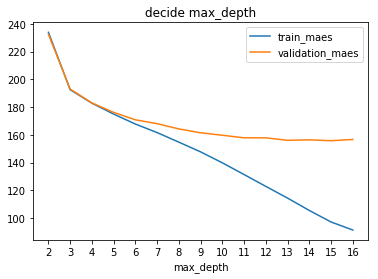

In [34]:
plt.plot(train_maes[:], label="train_maes")
plt.plot(val_maes[:], label="validation_maes")
plt.xticks(np.arange(n), np.arange(n)+n_start)
plt.xlabel("max_depth")
plt.title("decide max_depth")
plt.legend()

In [35]:
# 交差検証
t_maes = []
v_maes = []
n_splits = 5
i = 0
tmp = pd.DataFrame()
for train_idx, test_idx in KFold(n_splits=n_splits).split(X):
    X_train = X[train_idx]
    Y_train = Y[train_idx]
    X_val = X[test_idx]
    Y_val = Y[test_idx]
    
    rf = RandomForestRegressor(n_estimators = 10, max_depth = 13)
    rf.fit(X_train, Y_train)

    Y_train_pred = rf.predict(X_train)
    Y_val_pred = rf.predict(X_val)
    
    i+=1
    tmp[i] = rf.predict(X_test)
    
    t_maes.append(np.abs(Y_train_pred - Y_train).mean())
    v_maes.append( np.abs(Y_val_pred - Y_val).mean())

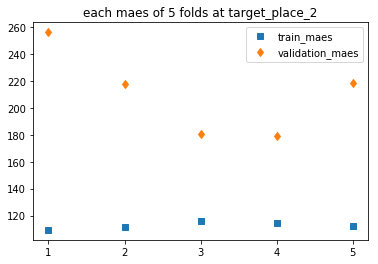

In [36]:
plt.plot(t_maes, 's', label="train_maes")
plt.plot(v_maes, 'd', label="validation_maes")
plt.legend()
plt.title("each maes of "+str(n_splits)+" folds at target_place_"+str(target_place))
plt.xticks(np.arange(n_splits), np.arange(n_splits)+1)
plt.show()

In [37]:
# 2016/01/01 00:00 ~ 2017/3/31 23:50の予測データを書き出す
predict_data["blending_"+str(target_place)] = np.array(tmp.mean(axis=1))

### **米倉山について**

In [38]:
target_place = 3

In [39]:
# 発電量データ
output_30 = all_output_30[['datetime', 'SOLA0'+str(target_place)]]
output_30 = scaling_output(output_30)

/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/kyojin/anaconda/envs/tf/lib/python3.5/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [40]:
# いろんなモデルの予測値の集合(学習用)
train_prediction = pd.read_csv("data/predicted_data/layer_1_train_SOLA0"+str(target_place)+".csv")
train_prediction['datetime'] = train_prediction['datetime'].map(lambda x : pd.to_datetime(x))

# いろんなモデルの予測値の集合(ほんちゃん)
test_prediction = pd.read_csv("data/predicted_data/layer_1_SOLA0"+str(target_place)+".csv")
test_prediction['datetime'] = test_prediction['datetime'].map(lambda x : pd.to_datetime(x))

In [41]:
# 発電量が0の時間を0にしておく
train_prediction = to_zero_df(train_prediction)
test_prediction = to_zero_df(test_prediction)

In [42]:
# 月, 時間の情報を加える
train_prediction = add_time_sincos(train_prediction)
test_prediction = add_time_sincos(test_prediction)

In [43]:
len(train_prediction.columns), len(test_prediction.columns)

(21, 21)

In [44]:
t_s_datetime = train_prediction['datetime'][0]
t_e_datetime = train_prediction['datetime'][len(train_prediction)-1]
train_y_s_idx = output_30[output_30['datetime'] == t_s_datetime].index[0]
train_y_e_idx = output_30[output_30['datetime'] == t_e_datetime].index[0]

X = np.array(train_prediction.drop(["datetime"], axis=1))
all_X = np.array(train_prediction.drop(["datetime"], axis=1))
Y = output_30["SOLA0"+str(target_place)][train_y_s_idx:train_y_e_idx+1]
X_test = np.array(test_prediction.drop(["datetime"], axis=1))

In [45]:
X = np.array(X)
Y = np.array(Y)
X, Y = drop_nan(X, Y)

In [46]:
# 最適な深さを決める

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=int((X.shape[0] * 0.3)))

train_maes = []
val_maes = []
n = 15
n_start = 2
for i in range(n):
    rf = RandomForestRegressor(n_estimators = 10, max_depth = i+n_start)
    rf.fit(X_train, Y_train)
    Y_train_pred = rf.predict(X_train)
    Y_val_pred = rf.predict(X_val)
    train_maes.append(np.abs(Y_train_pred - Y_train).mean())
    val_maes.append(np.abs(Y_val_pred - Y_val).mean())
#     print("train_mae : ", np.abs(Y_train_pred - Y_train).mean())
#     print("val_mae : ", np.abs(Y_val_pred - Y_val).mean())

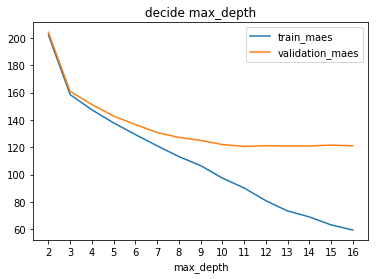

In [47]:
plt.plot(train_maes[:], label="train_maes")
plt.plot(val_maes[:], label="validation_maes")
plt.xticks(np.arange(n), np.arange(n)+n_start)
plt.xlabel("max_depth")
plt.title("decide max_depth")
plt.legend()

In [48]:
# 交差検証
t_maes = []
v_maes = []
n_splits = 5
i = 0
tmp = pd.DataFrame()
for train_idx, test_idx in KFold(n_splits=n_splits).split(X):
    X_train = X[train_idx]
    Y_train = Y[train_idx]
    X_val = X[test_idx]
    Y_val = Y[test_idx]
    
    rf = RandomForestRegressor(n_estimators = 10, max_depth = 13)
    rf.fit(X_train, Y_train)

    Y_train_pred = rf.predict(X_train)
    Y_val_pred = rf.predict(X_val)
    
    i+=1
    tmp[i] = rf.predict(X_test)
    
    t_maes.append(np.abs(Y_train_pred - Y_train).mean())
    v_maes.append( np.abs(Y_val_pred - Y_val).mean())

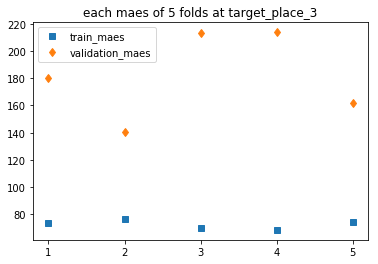

In [49]:
plt.plot(t_maes, 's', label="train_maes")
plt.plot(v_maes, 'd', label="validation_maes")
plt.legend()
plt.title("each maes of "+str(n_splits)+" folds at target_place_"+str(target_place))
plt.xticks(np.arange(n_splits), np.arange(n_splits)+1)
plt.show()

In [50]:
# 2016/01/01 00:00 ~ 2017/3/31 23:50の予測データを書き出す
predict_data["blending_"+str(target_place)] = np.array(tmp.mean(axis=1))

In [51]:
predict_data

,datetime,blending_1,blending_2,blending_3
0,2016-01-01 00:00:00,0.000927,0.000166,0.000010
1,2016-01-01 00:30:00,0.000927,0.000166,0.000010
2,2016-01-01 01:00:00,0.000927,0.000166,0.000010
3,2016-01-01 01:30:00,0.000927,0.000166,0.000010
4,2016-01-01 02:00:00,0.000927,0.000166,0.000010
5,2016-01-01 02:30:00,0.000927,0.000166,0.000010
6,2016-01-01 03:00:00,0.000927,0.000166,0.000010
7,2016-01-01 03:30:00,0.000927,0.000166,0.000010
8,2016-01-01 04:00:00,0.000927,0.000166,0.000010
9,2016-01-01 04:30:00,0.000927,0.000166,0.000010


In [52]:
predict_data.to_csv('data/predicted_data/layer_2_prediction.csv')